In [123]:
import torch
import yolov5
import torch.nn as nn
import cv2
from torchvision import transforms
from PIL import Image
import joblib
import sklearn
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import random
import numpy as np

### Någonting som behövdes med den nya modellen, fråga inte varför bara gör.

In [3]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [4]:
# Niclas sätt att importera yolov5
model_path = "./saved_models/fish_model_yolov5_24-01-23.pt"
fish_model = yolov5.load(model_path)
fish_model.conf = 0.14

YOLOv5  2024-1-19 Python-3.10.11 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 291 layers, 20871318 parameters, 0 gradients, 48.2 GFLOPs
Adding AutoShape... 


#### Fish Model

In [ ]:
# yolo_path = "C:/Users/emmel/Desktop/testning av yolov5/yolov5"
# model_path = "./saved_models/fish_model_yolov5_23-12-20.pt"

# fish_model = torch.hub.load(yolo_path, 'custom', path=model_path, source='local')
# fish_model.conf = 0.10

#### Sick Fish Model
Exempelkod för att ladda den modell vi väl använder:

In [7]:
#sick_model = joblib.load("./saved_models/my_random_forest.joblib")
loaded_model = load_model('./saved_models/cnn_model_cropped_more_data_23-1-24.h5')

#### Testbild

In [9]:
def random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Inga bilder hittades i mappen.")
        return None

    random_image = random.choice(image_files)

    img_path = os.path.join(folder_path, random_image)

    return img_path

In [133]:
folder_path = './dataset/test_img/Healthy_fishies/Sea Bass/'
test_image_path = random_image(folder_path)
image_path = "./dataset/test_img/Healthy_fishies/Red Mullet/00142.png"
original_image = cv2.imread(test_image_path)
image = Image.fromarray(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

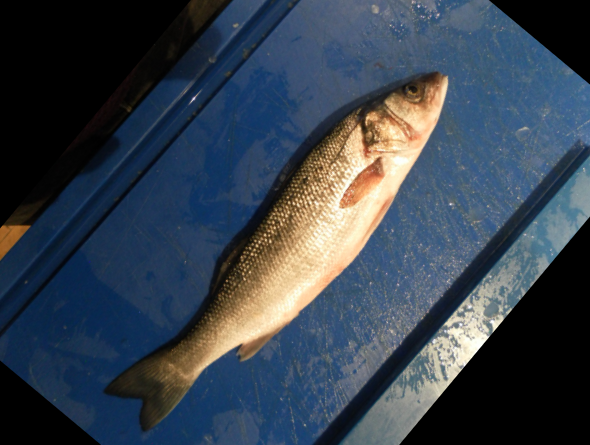

In [134]:
display(image)

In [135]:
yolo_result = fish_model(image)
yolo_preds = yolo_result.pandas().xyxy[0]

In [136]:
predictions = yolo_result.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

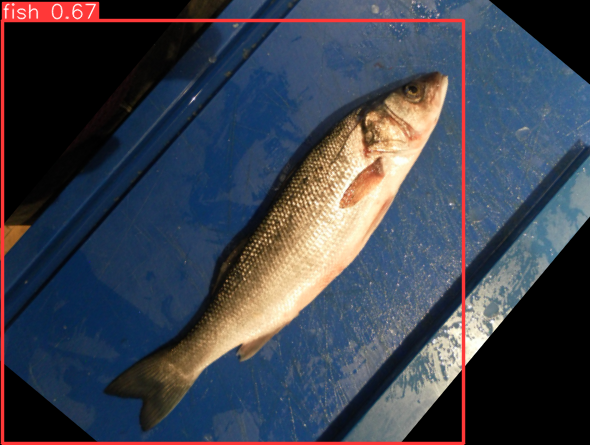

In [137]:
yolo_result.show()

In [70]:
loaded_model = load_model('./saved_models/cnn_model_cropped_more_data_23-1-24.h5')

In [50]:
def prepare_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [138]:
test_image = prepare_images([test_image_path])

# Gör prediktion med modellen
prediction = loaded_model.predict(test_image)

# Bestäm förutsagd klass och spara i listor
predicted_class_index = np.argmax(prediction[0])
class_labels = ["Diseased", "Healthy"]
predicted_class_label = class_labels[predicted_class_index]
confidence_score = prediction[0][predicted_class_index]

print(predicted_class_label, confidence_score)

1/1 [==============================] - 0s 13ms/step
Healthy 0.95801395


### Lets go!

       xmin       ymin       xmax        ymax  confidence  class  name
0  2.797852  20.654022  463.50354  443.258484    0.665275      0  fish
Fish detected
2 20 463 443


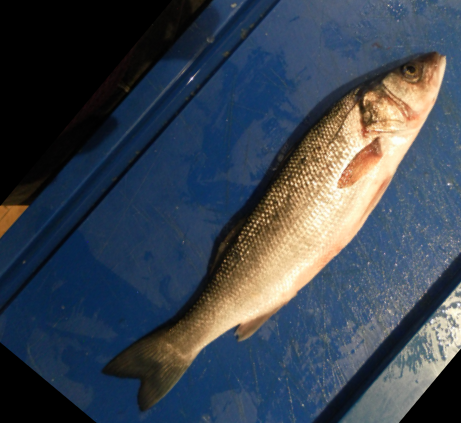

1/1 [==============================] - 0s 16ms/step
Healthy 0.808417


In [140]:
yolo_result = fish_model(image)
yolo_preds = yolo_result.pandas().xyxy[0]

print(yolo_preds)

if len(yolo_preds) > 0:
    print(f"Fish detected")
    
    for _, yolo_pred in yolo_preds.iterrows():
        bbox = yolo_pred[['xmin', 'ymin', 'xmax', 'ymax']].astype(int).tolist()
        # roi = original_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        print(bbox[0],bbox[1], bbox[2],bbox[3])
        crop_coordinates = (bbox[0],bbox[1],bbox[2],bbox[3])
        cropped_image = image.crop(crop_coordinates)

        cropped_image.save('test.jpg')

        display(cropped_image)

        cropped_image_array = img_to_array(cropped_image)
        cropped_image_array = tf.image.resize(cropped_image_array, (64, 64))
        cropped_image_array = np.expand_dims(cropped_image_array, axis=0)

        # Gör prediktion med modellen
        prediction = loaded_model.predict(cropped_image_array)

        predicted_class_index = np.argmax(prediction[0])
        class_labels = ["Diseased", "Healthy"]
        predicted_class_label = class_labels[predicted_class_index]
        confidence_score = prediction[0][predicted_class_index]

        print(predicted_class_label, confidence_score)

        # Preprocessing för sick model  

        # second_model_output = sick_model.predict([........])

        # print(f"Prediction for ROI: Class {second_model_output[0]}")

else:
    print(f"No fish detected")
